In [1]:
%matplotlib inline
#needed to in install arviz and pymc3
%pip install arviz
%pip install pymc3
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
az.style.use('arviz-darkgrid')
np.random.seed(44)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=f02bfb74ed6a808c4957d757e067bd355d56d20e75cf325290c715f68b586428
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [7, 3],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})
sns.set(rc={'figure.figsize':(7,3)})

In [79]:
base_dir = '"../data"'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Bayesian Project on Energy Consumption
### Authors: Bulloni Dyuman, Gamba Davide
### Supervisor: Corani, Giorgio

## Data Analysis

In [4]:
original_df = pd.read_csv(base_dir+'processed.csv', index_col=0).reset_index()

In [5]:
original_df.describe()

index  renewables_cons   fossil_cons
count    149.000000       149.000000    149.000000
mean    8613.067114      1257.063819   2104.415101
std     4983.148974      2816.870667   3114.430555
min      118.000000         0.453000      0.046000
25%     4604.000000        61.384000    142.966000
50%     8511.000000       349.694000   1085.091000
75%    13264.000000      1342.899000   2751.019000
max    17430.000000     26686.961000  17701.236000

In [6]:
original_df.groupby(by=['continent']).count()

index  country  renewables_cons  fossil_cons
continent                                                  
Africa            41       41               41           41
Asia              36       36               36           36
Europe            37       37               37           37
North America     19       19               19           19
Oceania            4        4                4            4
South America     12       12               12           12

In [7]:
original_df.head()

index      continent              country  renewables_cons  fossil_cons
0    118           Asia          Afghanistan           25.960        4.035
1    478         Africa              Algeria           17.283     1689.097
2    638         Africa               Angola          287.720       91.559
3    678  North America  Antigua and Barbuda          136.177     3385.417
4    798  South America            Argentina          785.446     2213.294

As we require a novel group for a next analysis and considering there are not other main continents, we decided to drop from the analysis Oceania (which has anyway very few data) and focus the analysis over the main 5 continents. 

In [8]:
df = original_df[original_df['continent'] != 'Oceania']
print(original_df.shape, df.shape)

(149, 5) (145, 5)


# The structure of the data

* The $j$ subscript refers to the $j$-th  continent (we have 5 continents).

*  $n_j$: number of nations with registered data by contient $j$.

*  $y_{ij}$:  fossil consumption per capita of the $i$-th nation of the continent $j$
    * $j \in \{1,2,…,5\}$, $i \in \{1,2,…,n_j\}$.

* The data set is constituted by  145 *sub-populations*. 
Each continent has a cluster of nations.

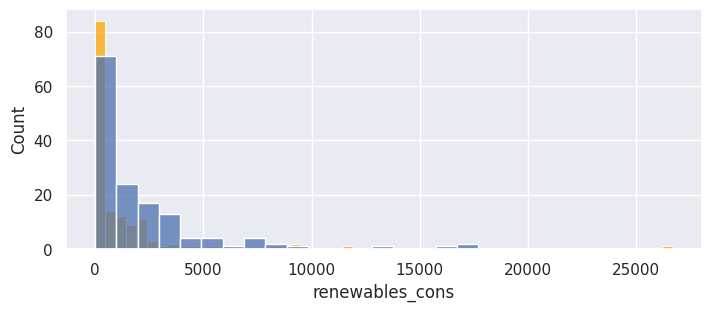

In [9]:
sns.histplot(df, x='renewables_cons', color='orange', label='renewables cons pa')
sns.histplot(df, x='fossil_cons', color='lightblue', label='fossil cons pa')
plt.legend()
plt.xlabel('Consumption per capita in kWh')
plt.title('Global Distribution of consumption per capita in 2018')

As the data is highly concentrated on the lower values, and has a long right tail, we operate on the logarithm of the data. 

In [10]:
df.loc[:,'renewables_cons'] = np.log(df['renewables_cons'])
df.loc[:,'fossil_cons'] = np.log(df['fossil_cons'])
df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


index      continent              country  renewables_cons  fossil_cons
0    118           Asia          Afghanistan         3.256557     1.395006
1    478         Africa              Algeria         2.849723     7.431949
2    638         Africa               Angola         5.661988     4.516984
3    678  North America  Antigua and Barbuda         4.913956     8.127232
4    798  South America            Argentina         6.666252     7.702237

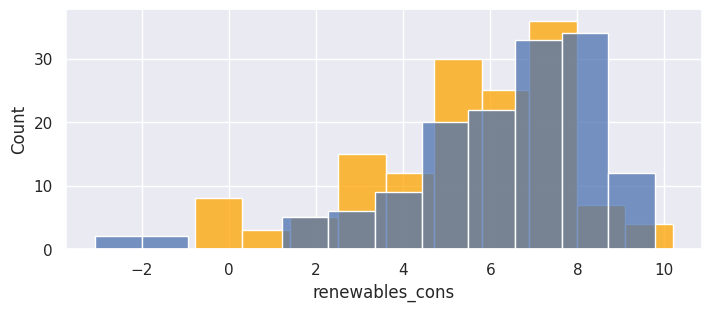

In [11]:
sns.histplot(df, x='renewables_cons', color='orange', label='renewables cons pa')
sns.histplot(df, x='fossil_cons', color='lightblue', label='fossil cons pa')
plt.legend()
plt.xlabel('Log-Consumption per capita in kWh')

plt.title('Global Log-Distribution of consumption per capita in 2018')

For semplicity, on this notebook from now on we will refer and plot only at the log-transformed data.

Text(0.5, 1.0, 'Log Boxplot per continent renewable consumption per capita in 2018')

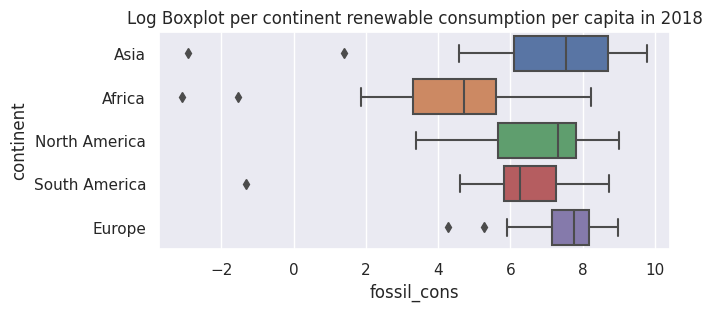

In [249]:
sns.boxplot(data=df, x="fossil_cons", y="continent");
plt.title('Log Boxplot per continent renewable consumption per capita in 2018')

Text(0.5, 1.0, 'Log Boxplot per continent fossil consumption per capita in 2018')

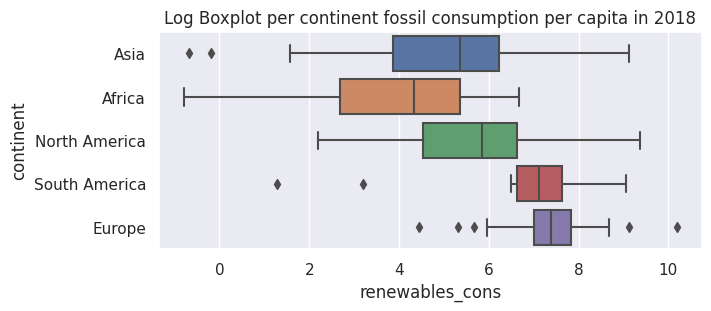

In [250]:
sns.boxplot(data=df, x="renewables_cons", y="continent");
plt.title('Log Boxplot per continent fossil consumption per capita in 2018')

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(*args, **kwargs)


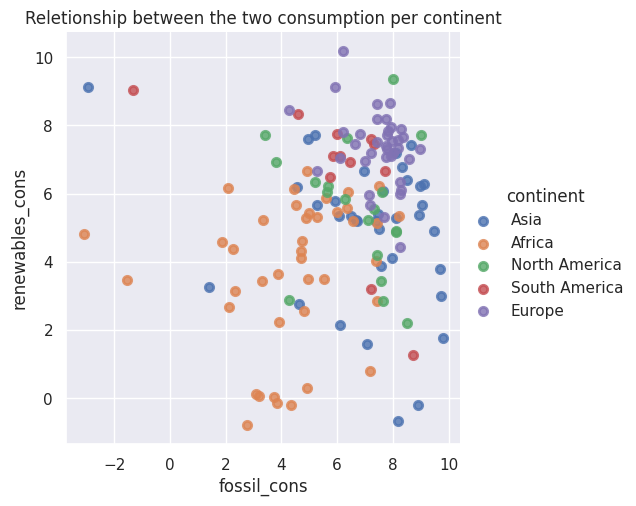

In [253]:
colors = {'North America':'green', 'South America':'red', 'Europe':'violet', 'Asia':'blue', 'Africa':'orange'}
sns.lmplot(data=df, x='fossil_cons', y='renewables_cons', hue='continent', fit_reg=False)
plt.title('Reletionship between the two consumption per continent')
plt.show()

The data are quite distributed over the space. 
As the proportion between the two consumption can heavily change between the continents, with few outliers for some continents such as Asia and South America. 

In [198]:
X = df['fossil_cons']
y = df['renewables_cons']

category = df['continent']
#names mapped into codes
cat_code  = category.astype('category').cat.codes
df['cat_code'] = cat_code

<ipython-input-198-6b0c46ef077f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cat_code'] = cat_code


# Pooled Model Regression (Non-hierarchical)

# Likelihood Definition
We assume that the distribution follows a Student-t distribution, as even with normalized data we have relevant tails. 
We are interested in the relationship between the fossil consumption per capita and renewable consumption per capita over the world, and also being able to evaluate nations that are not presented in our dataset, as those from the Oceania. 

Treat all continents the same by fitting a single model:

$$y_i \sim t_2( \alpha + \beta \cdot x_i, \sigma)$$

where:

* $y_i$: renewable consumption per capita,  measured in the $i$-th nation ($i$=1,2,...145)


* $\alpha$ : intercept. the mean of renewable consumption per capita over the world. 

* $\beta$ : slope. measurment of the strength and direction of the relationship between the two energy consumption per capita. 

* $x_i$: fossil consumption per capita measured for the $i$-th nation ($i$=1,2,...145)


* $\epsilon_i$  random variation of the measures 

Therefore, our likelihood function is defined in the following way: 
\begin{align*}
Y & \sim t_{\nu}(\alpha + \beta  \cdot x_i, \sigma_{\epsilon}))
\end{align*}

where $\nu$ is arbitrarily set to 2, as we want to consider long tails.

# Prior Estimation


## Weakly informative, data-dependent  priors

* We use the centered covariate  $X_c = X - \bar{x}$

A first approach to the prior estimation is the weakly informative, that cna at least provide information about the order of magnitude of the data. 

\begin{align}
Y  &\sim t_2( \alpha + \beta X_c,  \sigma) && \text{likelihood}\\
\alpha &\sim N(\bar{y},2 s_y) && \text{prior on the intercept} \\
\beta  & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y )&& \text{prior on the dev std } \\
\end{align}


In [20]:
X_c = X - X.mean()

prior_weakly_mu_y = y.mean()
prior_weakly_s_y = y.std()
prior_weakly_s_x = X_c.std()

In [45]:
def pooled_model(mu_y, s_y, s_x):
  with pm.Model() as pooled_model:
      # prior
      alpha = pm.Normal ('alpha', mu_y, 2*s_y)
      beta = pm.Normal ('beta', mu=0, sigma=2.5*s_y/s_x)
      sigma = pm.HalfNormal('sigma_y', 1.5 * s_y)

      #likelihood
      lik = alpha + pm.math.dot(X_c, beta)
      renewable_cons = pm.StudentT ('renewables_cons', nu=2, mu = lik,  sigma = sigma, observed =y)

      return pooled_model, pm.sample(3_000, tune=5_000, return_inferencedata=True, random_seed=42)

In [81]:
import pickle
def save_model_and_trace(filepath, model, trace):
  with open(filepath, 'wb') as file:
    pickle.dump({'model': model, 'trace': trace}, file)

def load_model_and_trace(filepath):
  with open(filepath, 'rb') as buff:
    data = pickle.load(buff)
  model = data['model']
  trace = data['trace']
  return model, trace

In [46]:
model_pooled_1, trace_pooled_1 = pooled_model(prior_weakly_mu_y, prior_weakly_s_y, prior_weakly_s_x)

In [83]:
pooled_1_filename = base_dir+'pooled_1.pkl'
save_model_and_trace(pooled_1_filename, model_pooled_1, trace_pooled_1)

In [84]:
model_pooled_1, trace_pooled_1 = load_model_and_trace(pooled_1_filename)

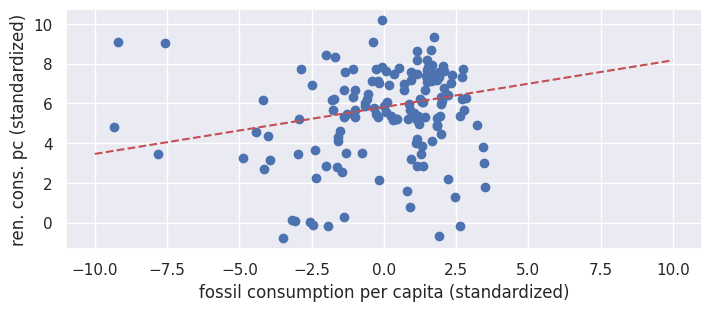

In [85]:
# posterior mean of the parameters
post_pooled = az.extract_dataset(trace_pooled_1)
a_pooled = post_pooled.alpha.values.mean()
b_pooled = post_pooled.beta.values.mean()

plt.scatter(X_c, y)
xvals = np.linspace(-10, 10)
plt.plot(xvals, b_pooled * xvals + a_pooled, 'r--')
plt.xlabel('fossil consumption per capita (standardized)')
plt.ylabel('ren. cons. pc (standardized)');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd4622d4c0>,
      dtype=object)

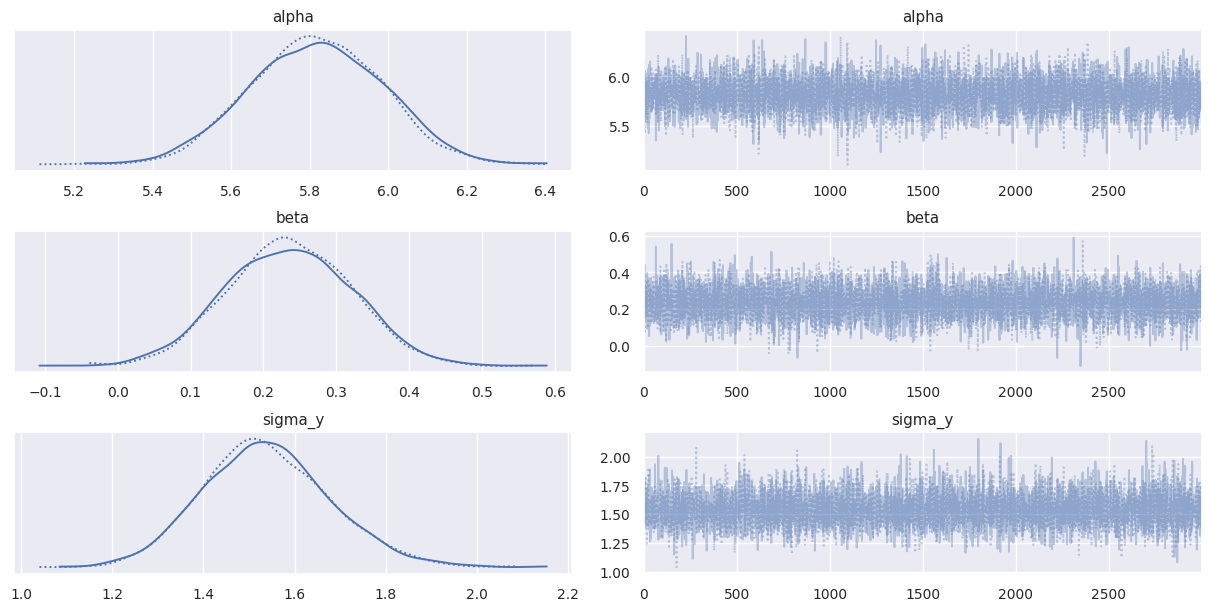

In [86]:
az.plot_trace(trace_pooled_1)

In [87]:
az.summary(trace_pooled_1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    5.817  0.170   5.501    6.129      0.002    0.001    7909.0   
beta     0.236  0.086   0.075    0.393      0.001    0.001    7024.0   
sigma_y  1.538  0.140   1.292    1.815      0.002    0.001    7787.0   

         ess_tail  r_hat  
alpha      4170.0    1.0  
beta       4569.0    1.0  
sigma_y    4571.0    1.0

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


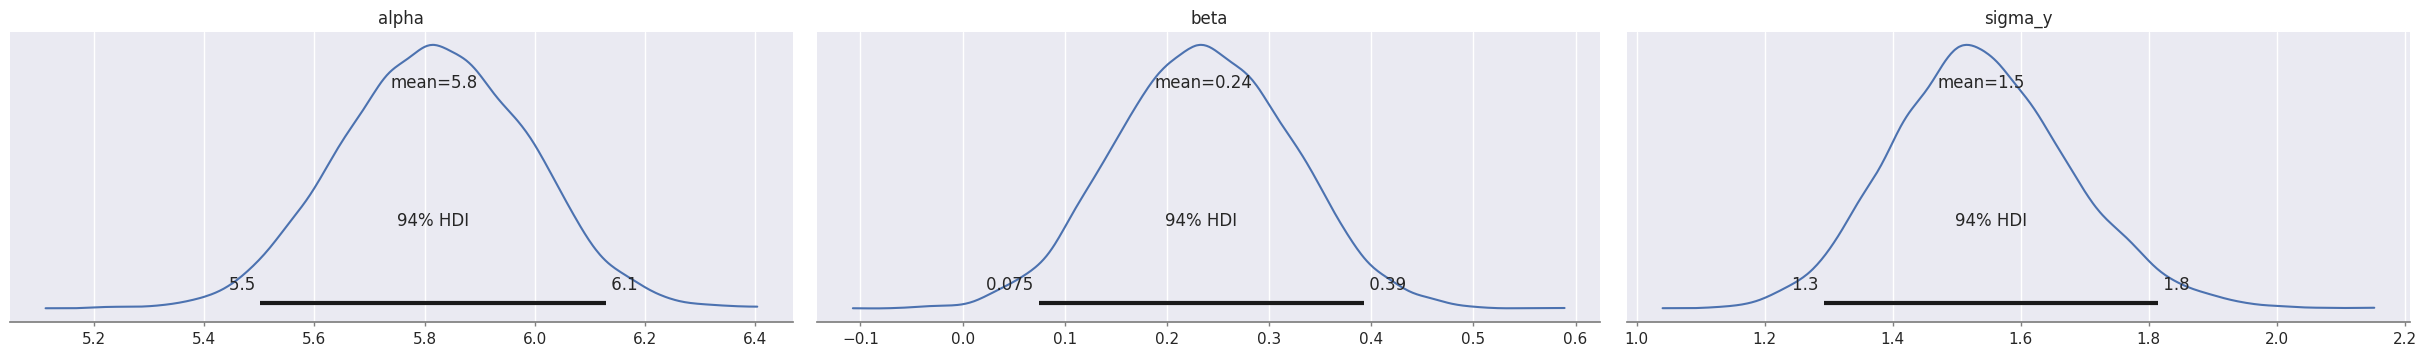

In [88]:
with model_pooled_1:
    az.plot_posterior(trace_pooled_1);

## Prediction for a novel continent

In [98]:
x_0= X.mean()
x_0

6.27428062859358

In [100]:

#prediction for a novel continent
post_pooled = az.extract_dataset(trace_pooled_1.posterior)

#posterior parameters of the population
a_population = post_pooled.alpha.values
b_population = post_pooled.beta.values
sigma_population = post_pooled.sigma_y.values

y_new = np.zeros(len(a_population))

for i in range(len(a_population)):
        # Estimated with a normal distribution
        y_new[i] = np.random.normal (loc = a_population[i] + b_population[i] *  x_0 , scale = sigma_population[i])

pred_novel = pd.DataFrame(y_new)
pred_novel.describe()

0
count  6000.000000
mean      7.293936
std       1.657617
min       0.036777
25%       6.183908
50%       7.286835
75%       8.401969
max      13.828930

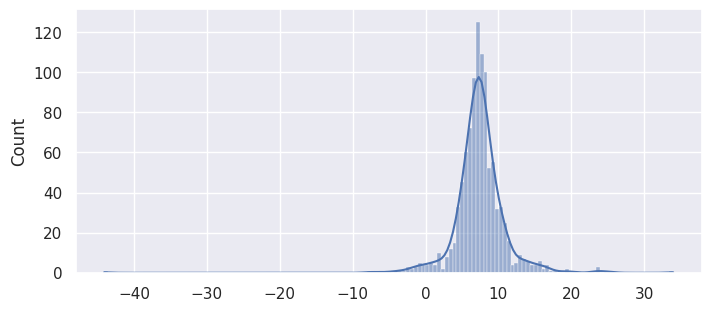

In [104]:
import scipy 
sns.histplot(scipy.stats.t.rvs(df=2, loc=pred_novel.describe().loc['mean',0], scale=pred_novel.describe().loc['std',0], size=1000, random_state=42),kde=True)

This is a reasonable prediction for the posterior distribution of a novel group for the target (renewables consumption per capita)

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(array([0.0025127 , 0.        , 0.0050254 , 0.        , 0.        ,
        0.0050254 , 0.0050254 , 0.04522864, 0.26634643, 0.76134877,
        0.94226333, 0.37941803, 0.07538107, 0.01005081, 0.        ,
        0.0025127 , 0.00753811, 0.0025127 , 0.        , 0.0025127 ]),
 array([1.78978027, 2.18775819, 2.58573611, 2.98371403, 3.38169195,
        3.77966987, 4.17764779, 4.57562571, 4.97360363, 5.37158155,
        5.76955947, 6.16753739, 6.56551531, 6.96349323, 7.36147116,
        7.75944908, 8.157427  , 8.55540492, 8.95338284, 9.35136076,
        9.74933868]),
 <a list of 20 Patch objects>)

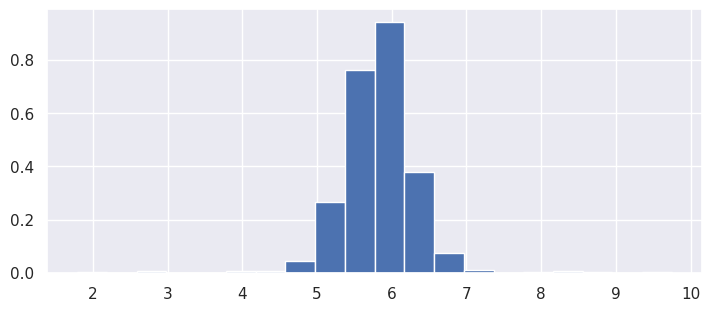

In [89]:
with model_pooled_1:
    ppc = pm.sample_posterior_predictive(trace_pooled_1, samples=1000, model=model_pooled_1, progressbar=True)
plt.hist(ppc['renewables_cons'].mean(axis=1), bins=20, density=True)


Given the value of fossil consumption per capita from the mean (the value used to center the data), the posterior distribution for a new group is defined by t_2

## Sensitivity analysis

We have, in fact, data of previous years. 
Another approach to estimate priors is to evaluate those data with the assumption that the distribution will be similar. 

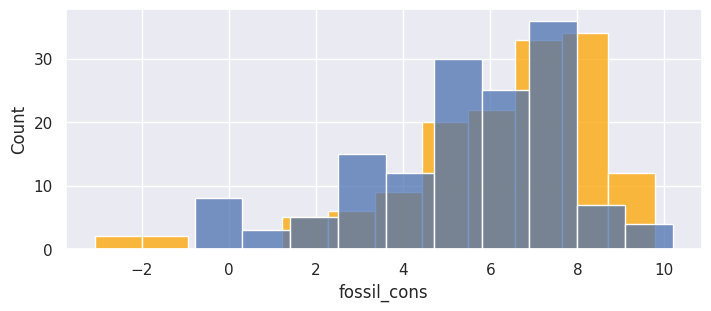

In [32]:
previous_year_df = pd.read_csv('/content/gdrive/MyDrive/Colab/processed.csv', index_col=0).reset_index()
previous_year_df = previous_year_df[previous_year_df['continent'] != 'Oceania']
previous_year_df.loc[:,'renewables_cons'] = np.log(previous_year_df['renewables_cons'])
previous_year_df.loc[:,'fossil_cons'] = np.log(previous_year_df['fossil_cons'])
#sns.histplot(previous_year_df, x='renewables_cons', color='orange')
sns.histplot(previous_year_df, x='fossil_cons', color='orange')
sns.histplot(previous_year_df, x='renewables_cons')

In [ ]:
previous_year_df.describe()

index  renewables_cons  fossil_cons
count    145.000000       145.000000   145.000000
mean    8633.289655         5.435181     6.274281
std     4981.517820         2.332581     2.351754
min      118.000000        -0.791863    -3.079114
25%     4604.000000         4.117149     4.936120
50%     8511.000000         5.778967     6.989419
75%    13264.000000         7.184437     7.919727
max    17430.000000        10.191930     9.781390

# Unpooled Model


\begin{align}
Y_j  &\sim t_2( \alpha_j + \beta_j X_c,  \sigma) && \text{likelihood}\\
\alpha_j &\sim N(\bar{y},2 s_y) j=1,2..., 5 && \text{prior on the intercepts per continent} \\
\beta_j  & \sim N (0,2.5 \frac{s_y}{s_x}) j=1,2..., 5  && \text{prior on the slope per continent} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y )&& \text{prior on the std dev} \\
\end{align}

In [59]:
n_continents = category.nunique()
unpooled_df = df.copy()
unpooled_df['fossil_cons']-= unpooled_df['fossil_cons'].mean()

In [63]:
X_c[cat_code]

1    1.157669
0   -4.879274
0   -4.879274
3    1.852952
4    1.427957
       ...   
1    1.157669
4    1.427957
1    1.157669
0   -4.879274
0   -4.879274
Name: fossil_cons, Length: 145, dtype: float64

In [165]:
def unpooled_model(mu_y, s_y, s_x):
  with pm.Model() as unpooled_model:
      # prior
      alpha = pm.Normal ('alpha', mu_y, 2*s_y, shape=n_continents)
      beta = pm.Normal ('beta', mu=0, sigma=2.5*s_y/s_x, shape=n_continents)
      sigma_y = pm.HalfNormal('sigma_y', 1.5 * s_y)

      #likelihood
      lik = pm.Deterministic('group_mu',alpha + pm.math.dot(X_c[cat_code], beta[cat_code]))
      renewable_cons = pm.StudentT ('renewables_cons', nu=2, mu = lik[cat_code],  sigma = sigma_y, observed =y)
      return unpooled_model, pm.sample(1_500, tune=3_000, max_treedepth=12,target_accept=0.9, return_inferencedata=True, random_seed=42)

In [166]:
model_unpooled_3, trace_unpooled_3 = unpooled_model(prior_weakly_mu_y, prior_weakly_s_y, prior_weakly_s_x)

ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [168]:
unpooled_3_filename = base_dir+'unpooled_3.pkl'
save_model_and_trace(unpooled_3_filename, model_unpooled_3, trace_unpooled_3)

In [173]:
model_unpooled, trace_unpooled = load_model_and_trace(unpooled_3_filename)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd39cf9e80>,
      dtype=object)

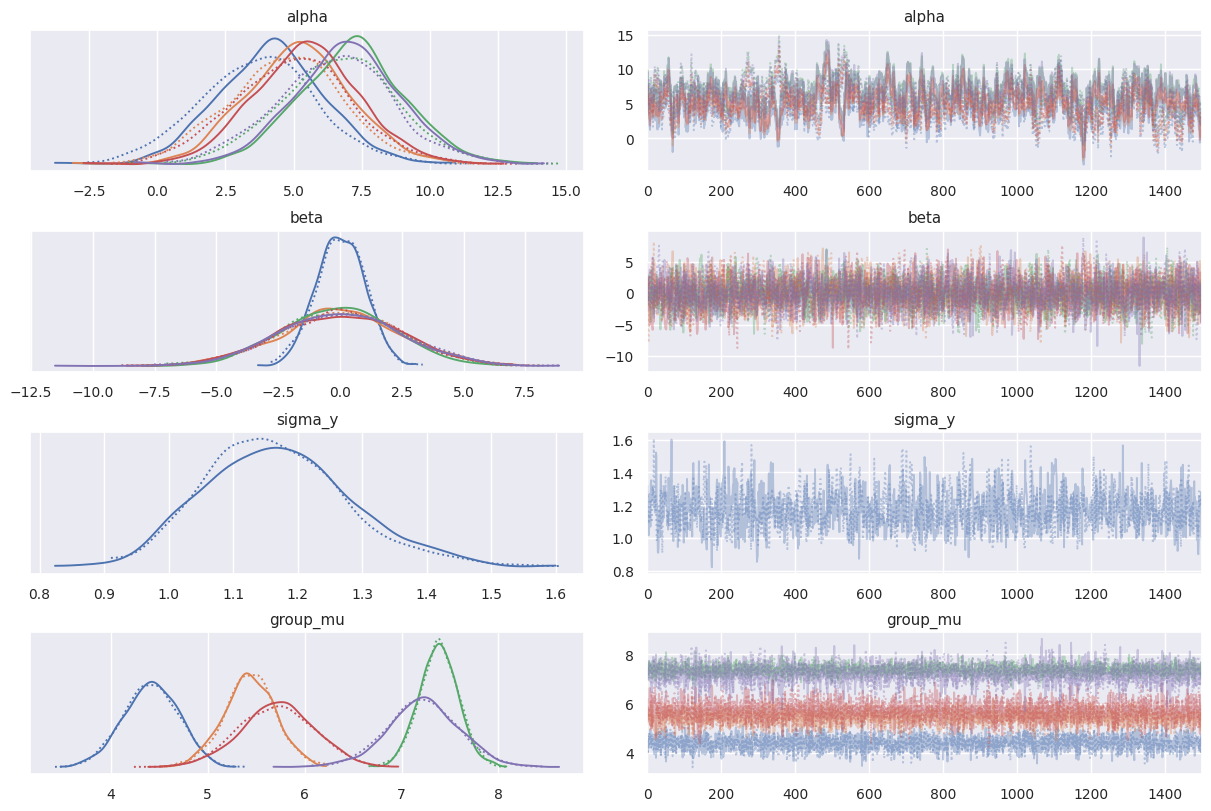

In [174]:
az.plot_trace(trace_unpooled)

In [175]:
az.summary(trace_unpooled)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]     3.938  2.096  -0.182    7.734      0.185    0.131     129.0   
alpha[1]     4.958  2.100   0.800    8.698      0.185    0.131     129.0   
alpha[2]     6.909  2.098   2.835   10.725      0.185    0.131     128.0   
alpha[3]     5.239  2.114   1.017    9.044      0.186    0.132     130.0   
alpha[4]     6.744  2.105   2.744   10.802      0.187    0.132     128.0   
beta[0]      0.030  0.971  -1.829    1.785      0.038    0.027     649.0   
beta[1]      0.058  2.440  -4.448    4.766      0.073    0.052    1114.0   
beta[2]     -0.058  2.292  -4.550    3.955      0.079    0.056     852.0   
beta[3]     -0.016  2.463  -4.546    4.753      0.073    0.051    1148.0   
beta[4]      0.057  2.481  -4.446    4.818      0.074    0.053    1117.0   
sigma_y      1.169  0.113   0.966    1.386      0.003    0.002    1081.0   
group_mu[0]  4.413  0.285   3.877    4.940      0.005    0.004    3226.0   
group_mu[1]  5.433  0.268   4.894    5.923      0.005    0.003    3290.0   
group_mu[2]  7.384  0.203   6.994    7.762      0.004    0.003    3134.0   
group_mu[3]  5.714  0.390   4.953    6.401      0.007    0.005    3114.0   
group_mu[4]  7.219  0.377   6.470    7.898      0.007    0.005    3177.0   

             ess_tail  r_hat  
alpha[0]        302.0   1.03  
alpha[1]        262.0   1.04  
alpha[2]        278.0   1.03  
alpha[3]        292.0   1.04  
alpha[4]        276.0   1.04  
beta[0]         933.0   1.00  
beta[1]        1552.0   1.00  
beta[2]        1196.0   1.01  
beta[3]        1488.0   1.00  
beta[4]        1380.0   1.00  
sigma_y        1205.0   1.00  
group_mu[0]    2346.0   1.00  
group_mu[1]    2268.0   1.00  
group_mu[2]    2329.0   1.00  
group_mu[3]    2091.0   1.00  
group_mu[4]    1987.0   1.00

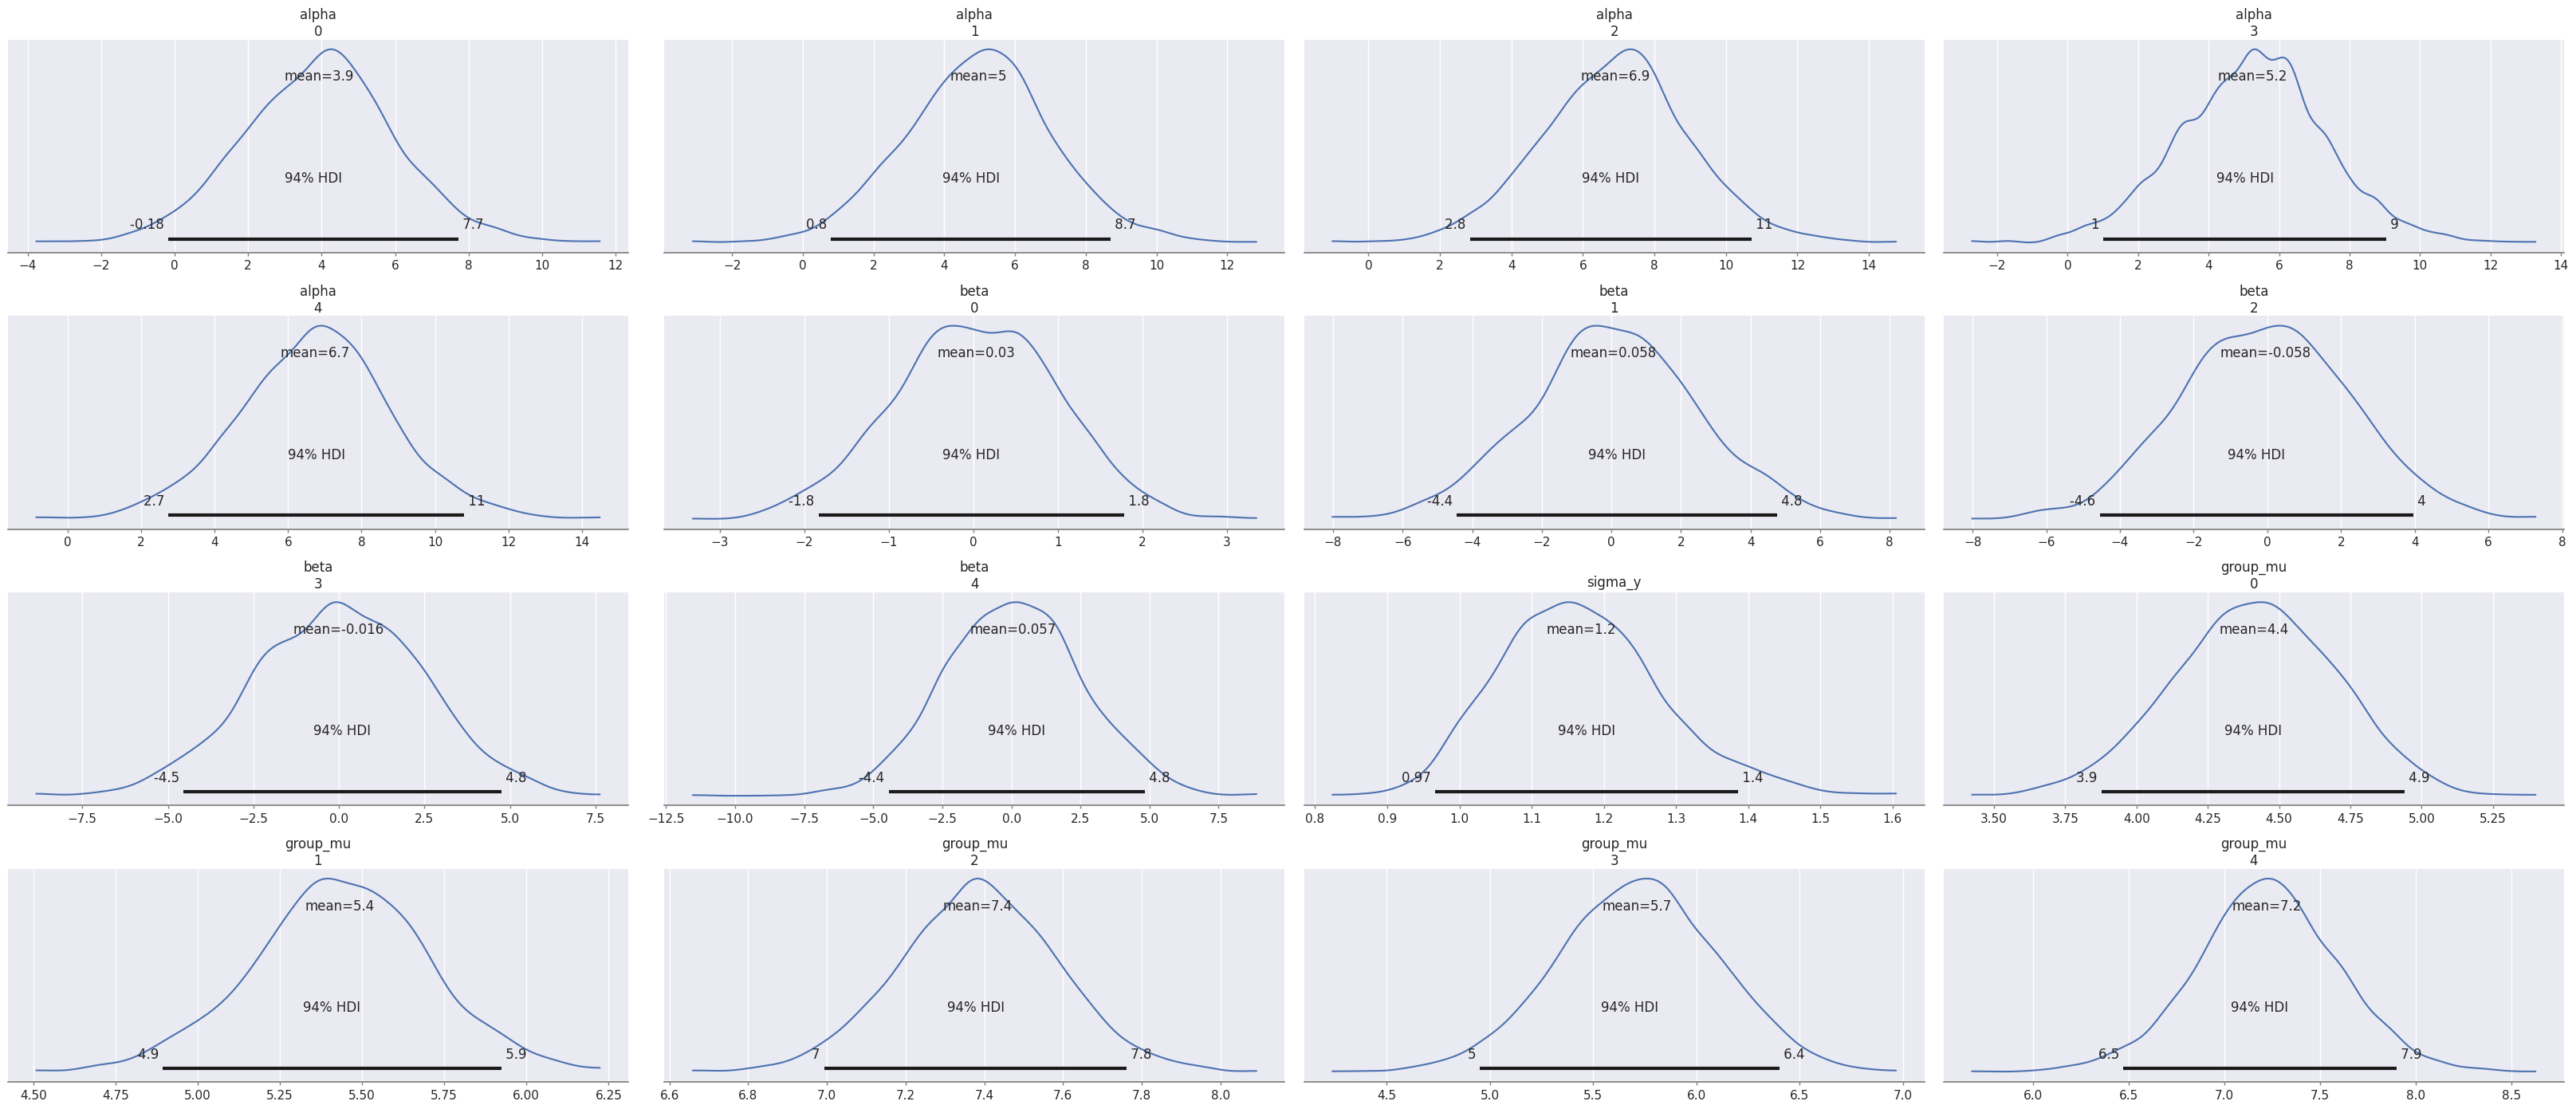

In [176]:
with model_unpooled:
    az.plot_posterior(trace_unpooled);

array([ True, False, False, False, False])

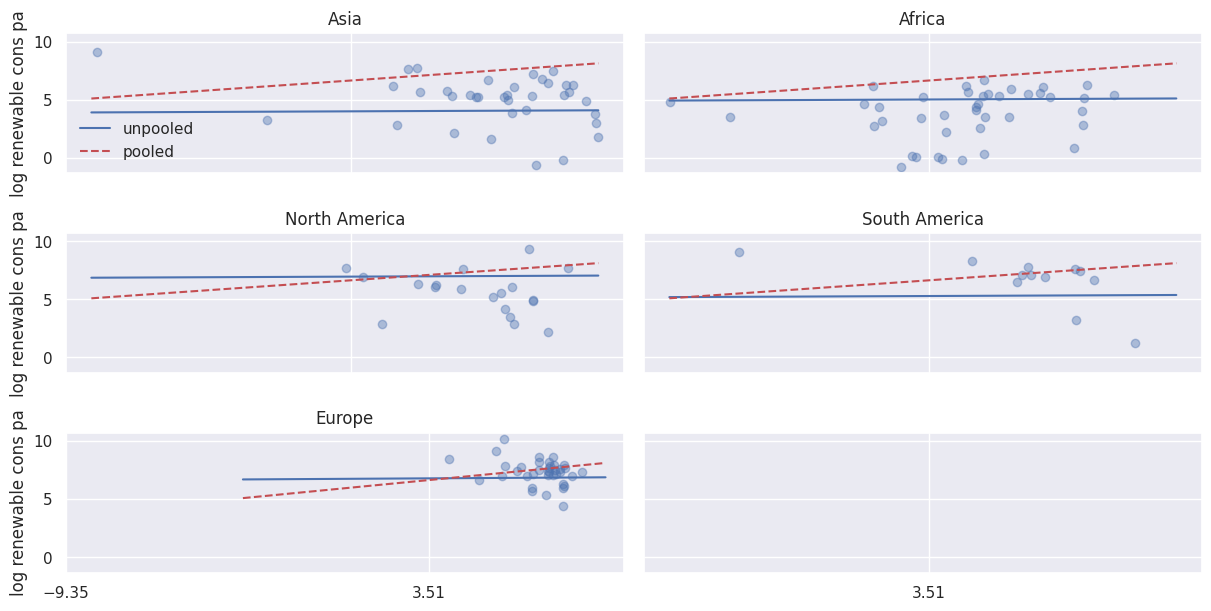

In [183]:

#The code below shows the pooled and unpooled model for some sample counties.
continent_names = category.unique()
continent_codes =  cat_code.unique()
fig, axes = plt.subplots(3, 2, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

#slope of the unpooled model (posterior mean)
unpooled_post = az.extract_dataset(trace_unpooled)
beta_unpooled = unpooled_post.beta.values.mean()

alpha_unpooled = pd.Series(unpooled_post.alpha.values.mean(axis=1), index=continent_names)

for i,c in enumerate(continent_names):
    #select the subset of observation referring to the specific county
    y_i = y[category==c]
    x_i = X[category==c]
    axes[i].scatter(x_i + np.random.randn(len(x_i))*0.01, y_i, alpha=0.4)
    

    # Plot both models and data
    xvals = np.linspace(X.min(), X.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[c] + beta_unpooled * xvals,  label="unpooled" )
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    axes[i].set_xticks([X_c.min(), X_c.max()])
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log renewable cons pa')
    axes[0].legend()

plt.savefig(base_dir+'pooled_unpooled.png')

## Posterior distribution for the mean of Europe

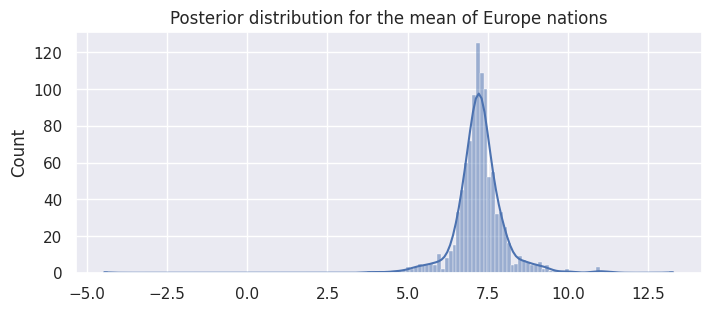

In [245]:
with model_unpooled:
    mu_europe = az.summary(trace_unpooled).loc['group_mu[4]','mean']
    sd_europe = az.summary(trace_unpooled).loc['group_mu[4]','sd']
    sns.histplot(scipy.stats.t.rvs(df=2, loc=mu_europe, scale=sd_europe, size=1000, random_state=42),kde=True)
    plt.title("Posterior distribution for the mean of Europe nations")

## Hierarchical Model

\begin{align}
Y &\sim N( \alpha_{j} + \beta_j X_c,  \sigma) && \text{likelihood} \\
\beta_j & \sim N (0,2  \frac{s_y}{s_x} ) j=1,2..., 5 && \text{prior on the slopes per continent} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the std dev} \\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 5&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(\bar{y},10 s_y)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of intercepts}\\
\end{align}

In [148]:
def hierarchical_model(mu_y, s_y, s_x):
  with pm.Model() as hier_model:
      
      # Parameters of the population of intercepts, to which we assign broad priors.
      mu_a     = pm.Normal('mu_a', mu=mu_y, sigma=10 * s_y)
      sigma_a = pm.HalfNormal('sigma_a', 5 * s_y)
      
      # Each intercept is drawn from the population of intercepts
      alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_continents)
      
      beta = pm.Normal('beta', mu=0, sigma= 2.5 *  s_y / s_x, shape=n_continents)
      
      sigma_y = pm.HalfNormal('sigma_y', 1.5 * s_y)


      lik = pm.Deterministic('group_mu',alpha[cat_code] + pm.math.dot(X_c[cat_code], beta[cat_code]))
      renewable_cons = pm.StudentT ('renewables_cons', nu=2, mu = lik,  sigma = sigma_y, observed =y)

      return hier_model, pm.sample(2000, tune=4_000, max_treedepth=12,target_accept=0.9, return_inferencedata=True, random_seed=42)

In [149]:
model_hier_3, trace_hier_3 = hierarchical_model(prior_weakly_mu_y, prior_weakly_s_y, prior_weakly_s_x)

In [150]:
hier_3_filename = base_dir+'hier_3.pkl'
save_model_and_trace(hier_3_filename, model_hier_3, trace_hier_3)

In [151]:
model_hier, trace_hier = load_model_and_trace(hier_3_filename)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd397b8fa0>,
      dtype=object)

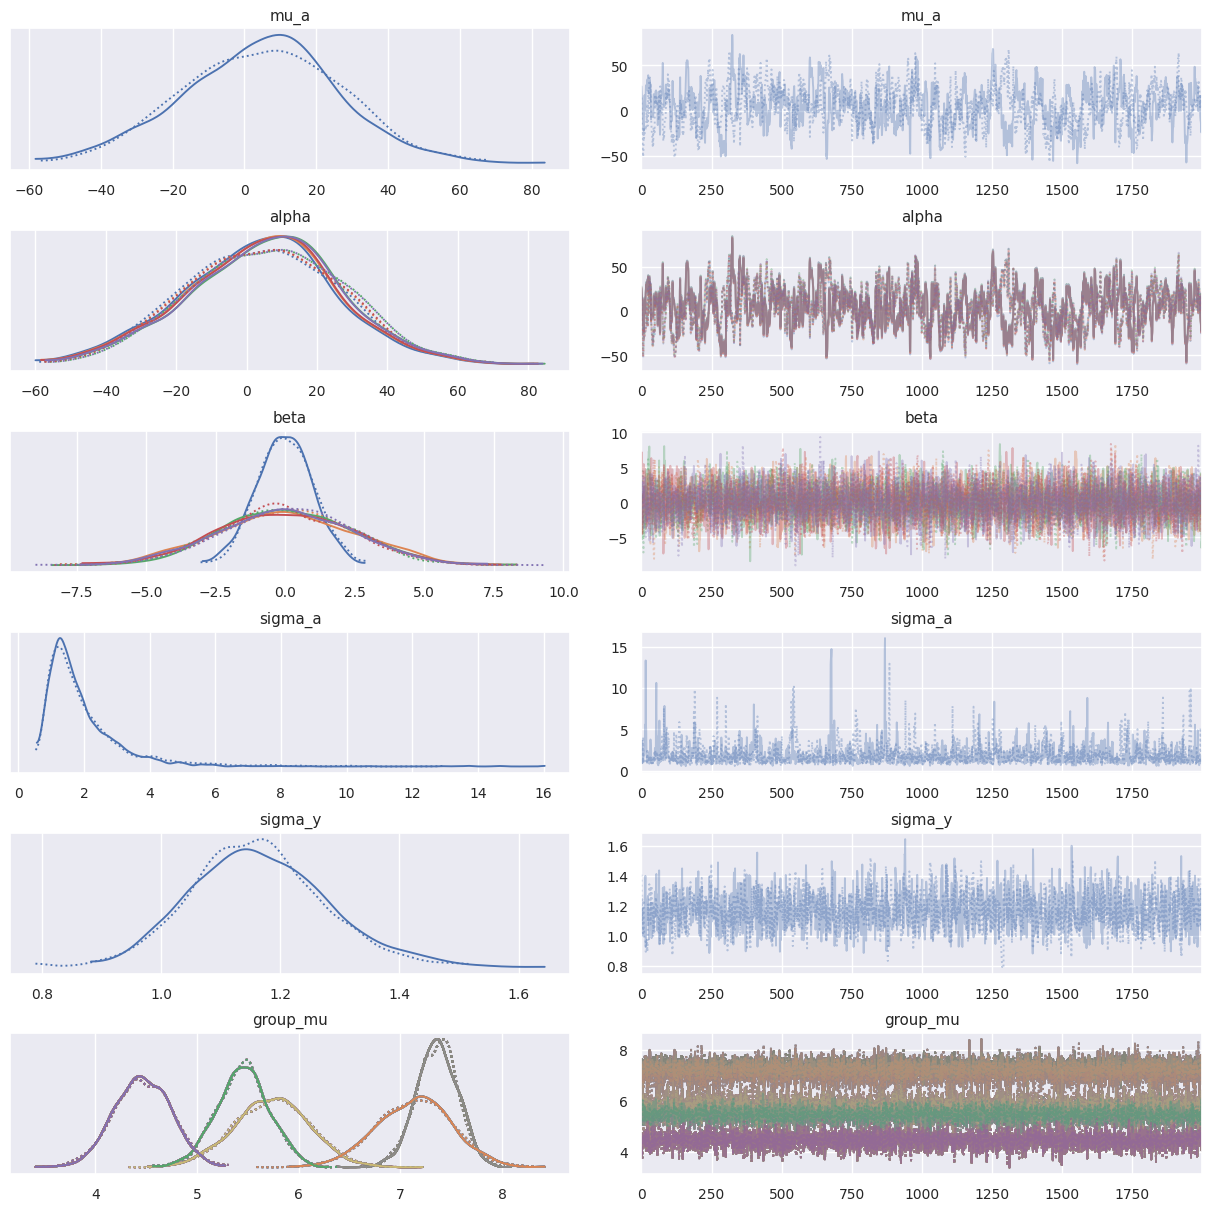

In [152]:
az.plot_trace(trace_hier)

In [186]:
# Cut down as we have no interest for all 145 group mu
az.summary(trace_hier)[:15]

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_a         4.726  21.680 -36.539   44.902      1.312    0.929     274.0   
alpha[0]     3.152  21.680 -38.168   42.813      1.311    0.928     274.0   
alpha[1]     4.139  21.672 -37.235   43.785      1.311    0.928     274.0   
alpha[2]     6.050  21.676 -34.907   46.187      1.312    0.929     274.0   
alpha[3]     4.426  21.678 -36.361   44.501      1.312    0.929     274.0   
alpha[4]     5.826  21.671 -35.067   46.243      1.312    0.929     274.0   
beta[0]     -0.012   1.002  -1.715    2.068      0.034    0.024     860.0   
beta[1]      0.044   2.488  -4.683    4.560      0.068    0.048    1326.0   
beta[2]      0.046   2.350  -4.194    4.407      0.077    0.054     932.0   
beta[3]     -0.026   2.402  -4.659    4.339      0.062    0.044    1518.0   
beta[4]      0.056   2.399  -4.563    4.424      0.061    0.043    1545.0   
sigma_a      1.956   1.280   0.584    4.029      0.046    0.033    1031.0   
sigma_y      1.163   0.114   0.959    1.391      0.003    0.002    1501.0   
group_mu[0]  5.450   0.260   4.984    5.952      0.004    0.003    3803.0   
group_mu[1]  4.463   0.280   3.965    5.011      0.004    0.003    3958.0   

             ess_tail  r_hat  
mu_a            541.0   1.01  
alpha[0]        523.0   1.01  
alpha[1]        520.0   1.01  
alpha[2]        521.0   1.01  
alpha[3]        528.0   1.01  
alpha[4]        520.0   1.01  
beta[0]        1394.0   1.00  
beta[1]        1707.0   1.00  
beta[2]        1337.0   1.00  
beta[3]        2111.0   1.00  
beta[4]        1927.0   1.00  
sigma_a         855.0   1.00  
sigma_y        1645.0   1.00  
group_mu[0]    3483.0   1.00  
group_mu[1]    3276.0   1.00

/usr/local/lib/python3.8/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (158) in plot_posterior, generating only 40 plots
  warnings.warn(


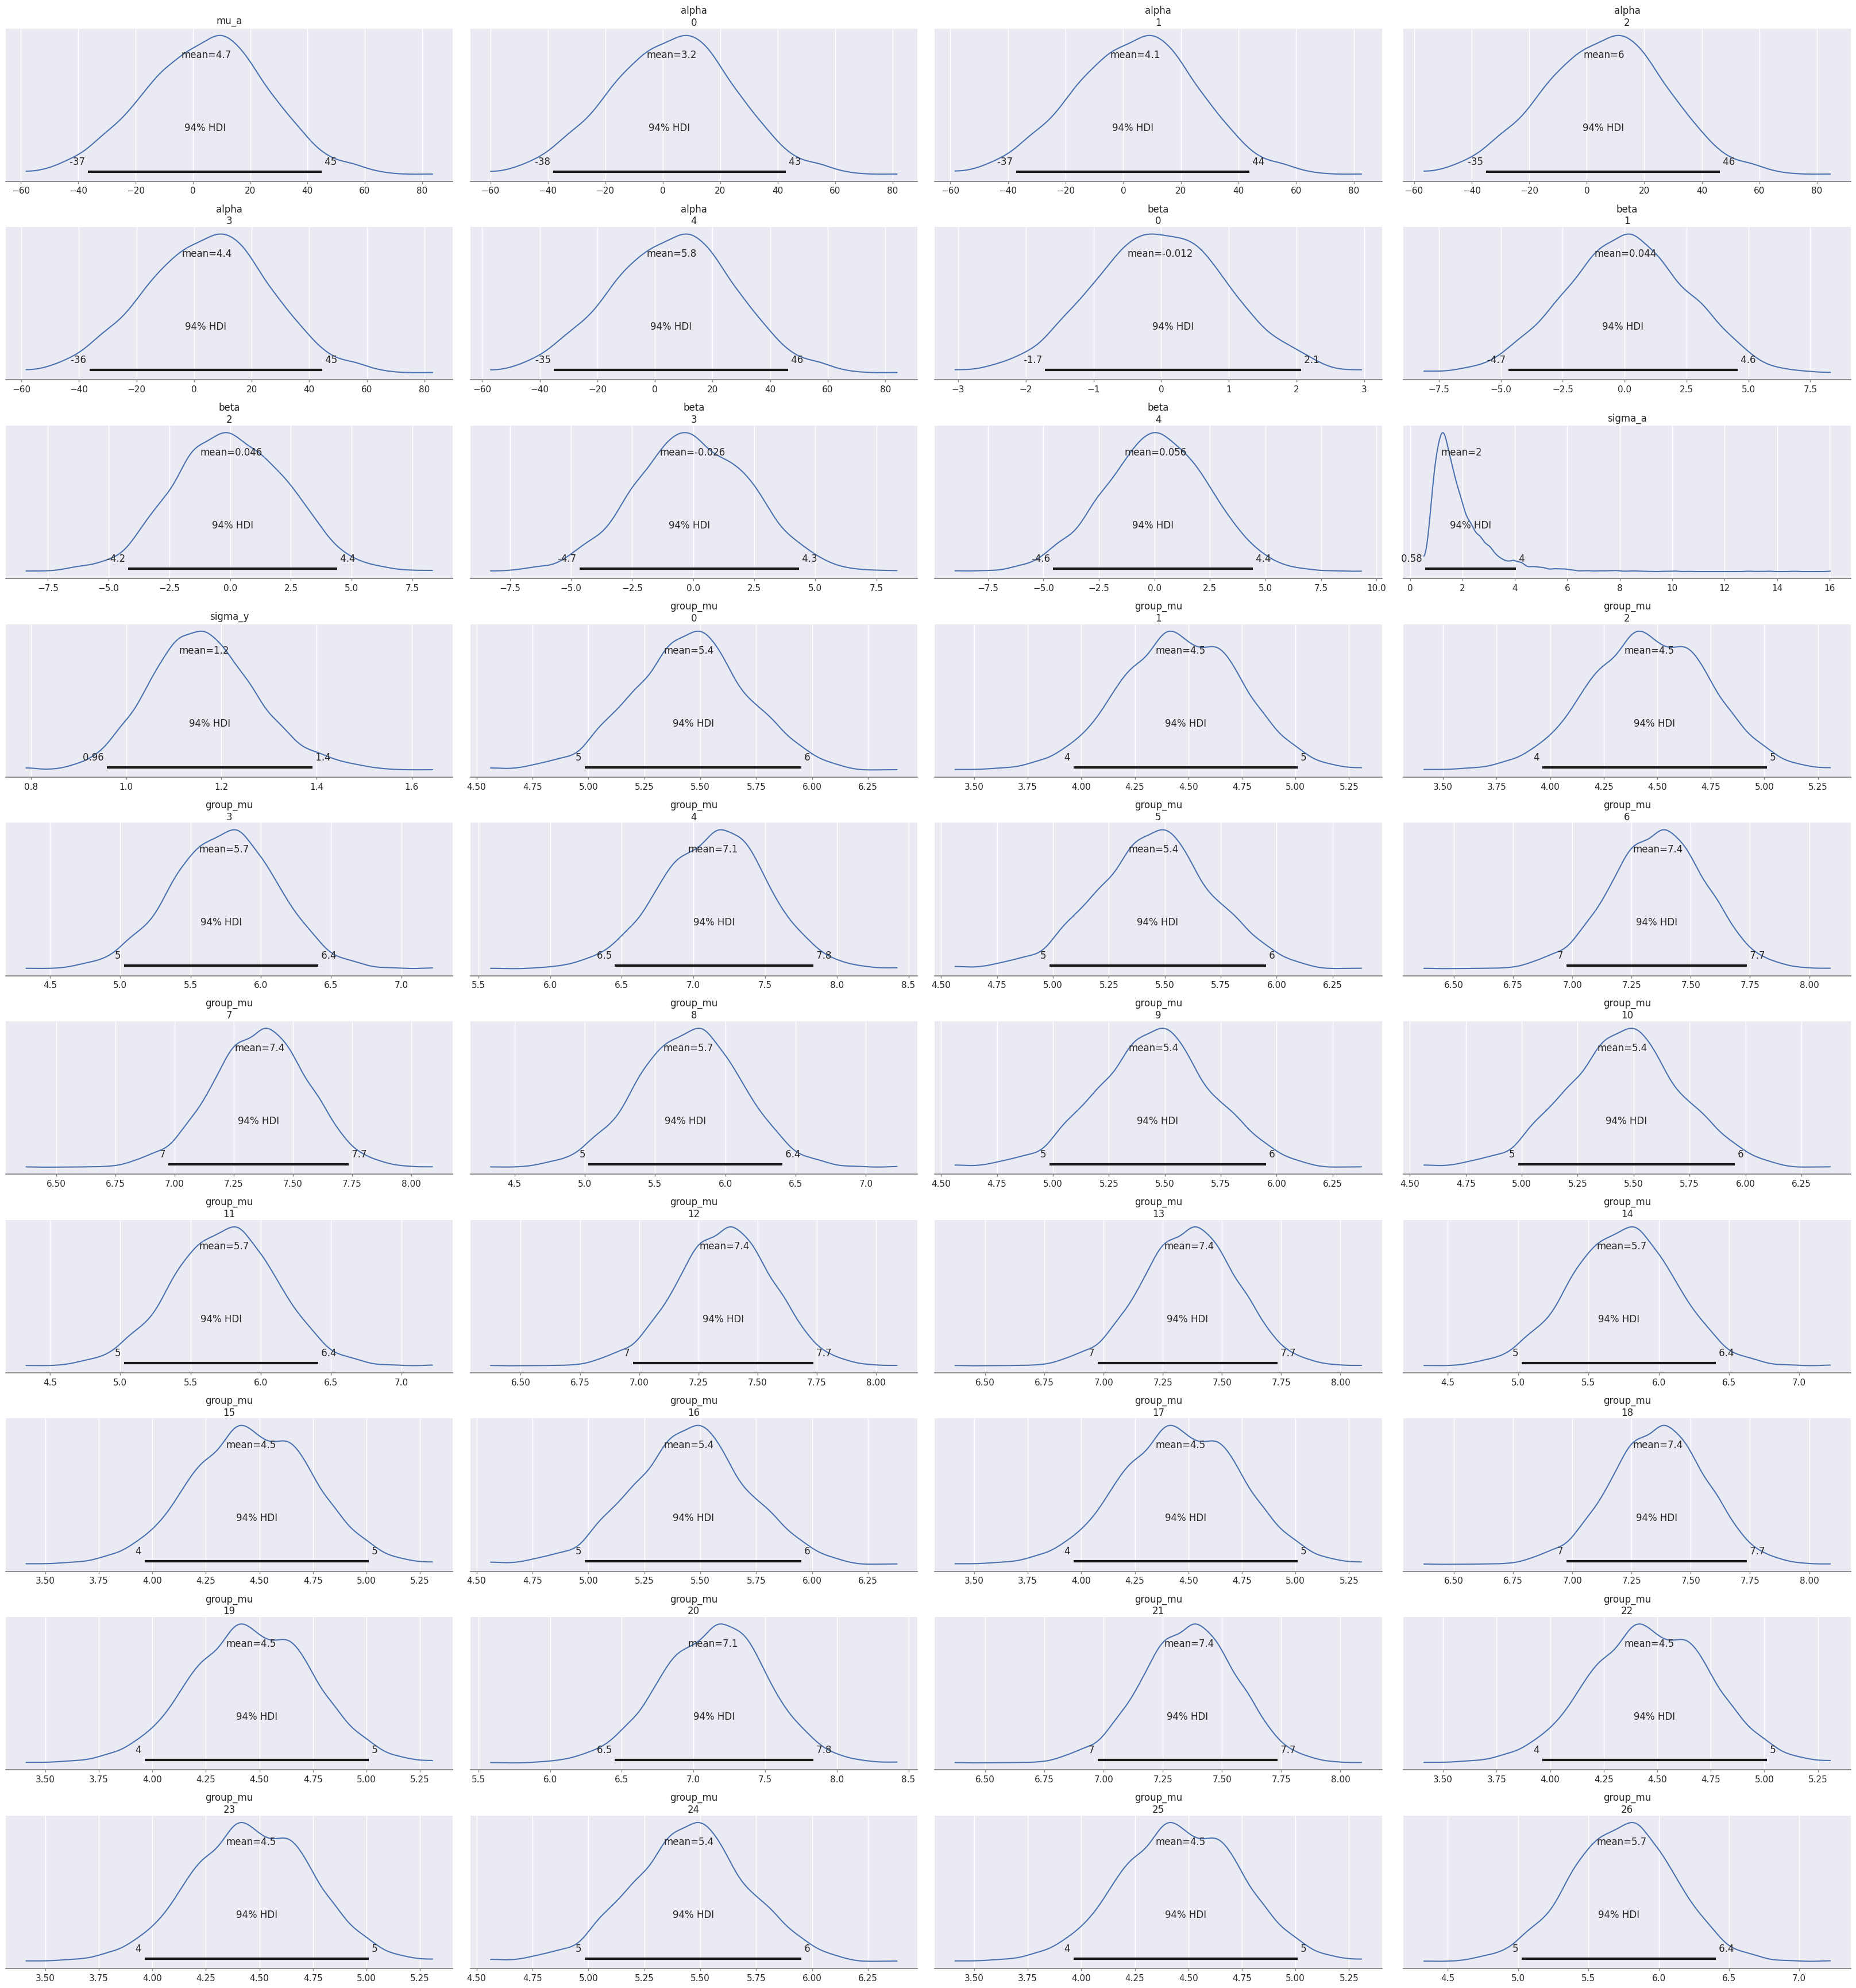

In [187]:
with model_hier:
    az.plot_posterior(trace_hier);

In [192]:
category.unique()

array(['Asia', 'Africa', 'North America', 'South America', 'Europe'],
      dtype=object)

In [193]:
alpha_unpooled[category.unique()==c]

Asia    3.93776
dtype: float64

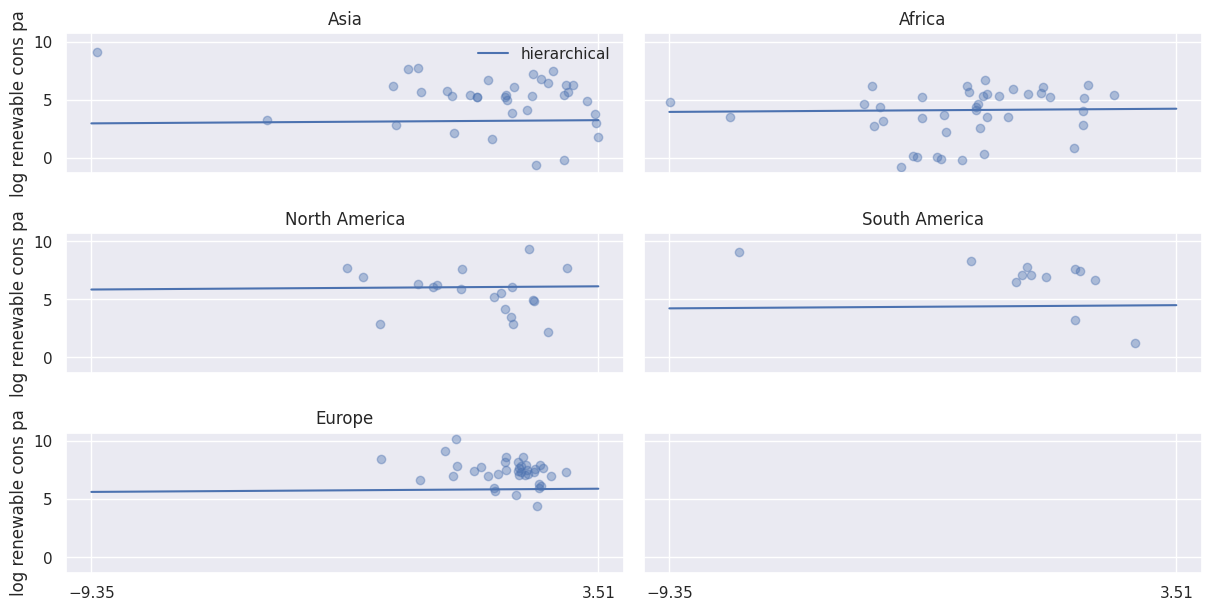

In [204]:
#%%

#the code below compare the estimates provided by the pooled, unpooled and hierarchical model
fig, axes = plt.subplots(3,2, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

post_hier   = az.extract_dataset(trace_hier.posterior)

#slope of the hier model (posterior mean)
beta_hier = post_hier.beta.values.mean()

# intercept of the hier model: an array, one element for each county (samples of each county are averaged)
alpha_hier = pd.Series(post_hier.alpha.values.mean(axis=1), index=continent_names)


for i,c in enumerate(continent_names):
    
    # Plot county data
    y_i = y[category==c]
    x_i = X_c[category==c]
    axes[i].scatter(x_i + np.random.randn(len(x_i))*0.01, y_i, alpha=0.4)

    
    xvals = np.linspace(X_c.min(), X_c.max() )
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[c] + beta_hier * xvals,  label="hierarchical" )
    #axes[i].plot(xvals, mp*xvals+ beta_hier[county_lookup[c]], 'k:')
    
    axes[i].set_xticks([X_c.min(), X_c.max()])
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log renewable cons pa')
    axes[0].legend()

plt.savefig(base_dir+'hier.png') 


## Predictive distribution for a new nation in Europe

In [247]:

post_hier    = az.extract_dataset(trace_hier.posterior)

#samples of the slope
beta_hier =  post_hier.beta.values

alpha_europe_hier = post_hier.alpha.values[continent_names == 'Europe',:] [0]
beta_europe_hier = post_hier.beta.values[continent_names == 'Europe',:] [0]

#samples of sd
sigma_y_hier =  post_hier.sigma_y.values

y_new_hier = np.zeros(len(beta_europe_hier))

for i, current_mu in enumerate(beta_europe_hier):
        y_new_hier[i] = np.random.normal (loc = alpha_europe_hier[i] + beta_europe_hier[i] *  x_0 , scale = sigma_y_hier[i])

#the predictive distribution of the unpooled is much larger median and more uncertaint (larger std)        
pred_new_in_europe=  pd.DataFrame(y_new_hier).describe()
pred_new_in_europe.columns = ['hier']
pred_new_in_europe

hier
count  4000.000000
mean      6.172870
std      26.914569
min     -80.902454
25%     -11.958005
50%       6.238157
75%      25.351092
max      95.056070

Text(0.5, 1.0, 'Predictive Distribution for a new nation in Europe')

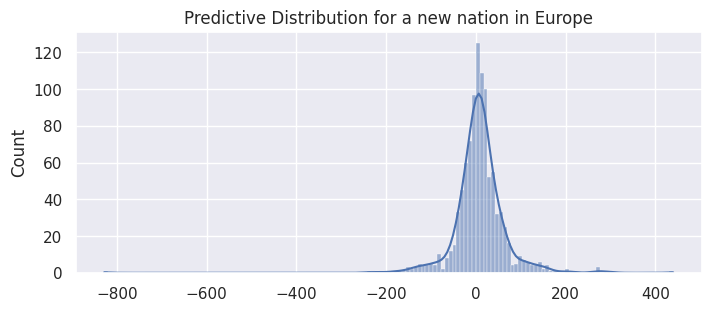

In [248]:
sns.histplot(scipy.stats.t.rvs(df=2, loc=pred_new_in_europe.loc['mean','hier'], scale=pred_new_in_europe.loc['std','hier'], size=1000, random_state=42),kde=True)
plt.title('Predictive Distribution for a new nation in Europe')

The outliers are harmful for this prediction, as they make explode the standard deviation. 

## Model Confrontation

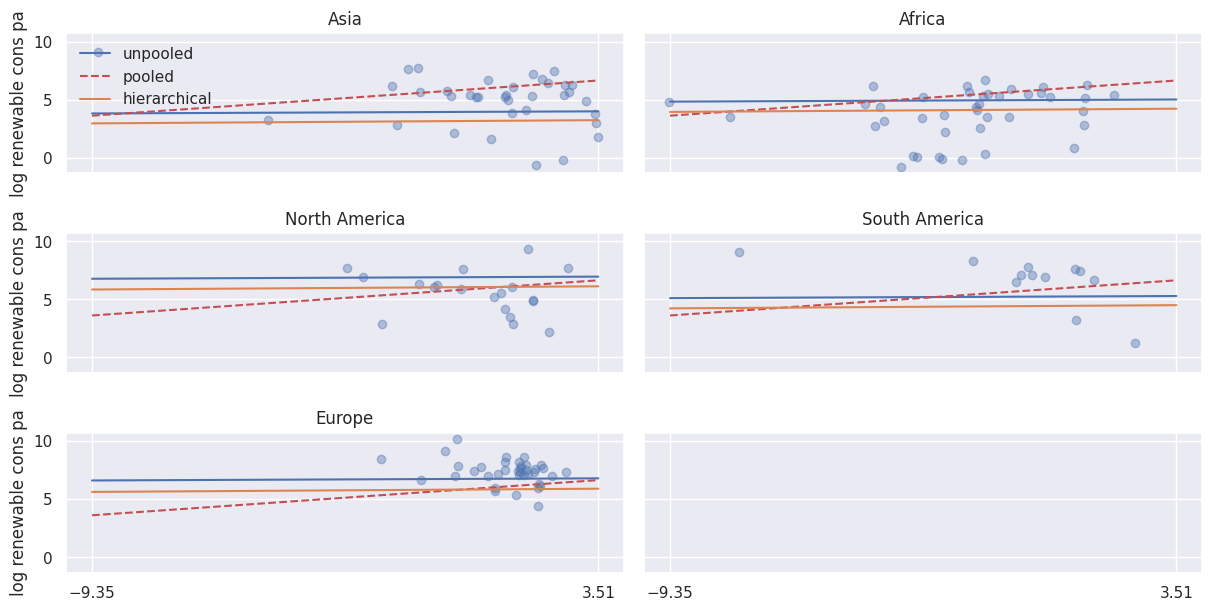

In [203]:
#%%

#the code below compare the estimates provided by the pooled, unpooled and hierarchical model
fig, axes = plt.subplots(3,2, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

post_hier   = az.extract_dataset(trace_hier.posterior)

#slope of the hier model (posterior mean)
beta_hier = post_hier.beta.values.mean()

# intercept of the hier model: an array, one element for each county (samples of each county are averaged)
alpha_hier = pd.Series(post_hier.alpha.values.mean(axis=1), index=continent_names)


for i,c in enumerate(continent_names):
    
    # Plot county data
    y_i = y[category==c]
    x_i = X_c[category==c]
    axes[i].scatter(x_i + np.random.randn(len(x_i))*0.01, y_i, alpha=0.4)

    
    xvals = np.linspace(X_c.min(), X_c.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[c] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[c] + beta_hier * xvals,  label="hierarchical" )
    #axes[i].plot(xvals, mp*xvals+ beta_hier[county_lookup[c]], 'k:')
    
    axes[i].set_xticks([X_c.min(), X_c.max()])
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log renewable cons pa')
    axes[0].legend()

plt.savefig(base_dir+'pooled_unpooled_hier.png') 


In [206]:
comp_df = az.compare({"model_pooled": trace_pooled_1,
                      "model_unpooled": trace_unpooled,
                      "model_hierarchical": trace_hier},
                      ic="waic") # ic stands for "information criterion"
comp_df

rank        waic    p_waic     d_waic  weight         se  \
model_hierarchical     0 -300.354901  6.145823   0.000000     1.0  12.261456   
model_unpooled         1 -300.436812  6.276407   0.081911     0.0  12.167620   
model_pooled           2 -332.807498  3.532609  32.452596     0.0  10.939015   

                         dse  warning waic_scale  
model_hierarchical  0.000000    False        log  
model_unpooled      0.314603    False        log  
model_pooled        6.448823    False        log

As expected, the hierarchical model performed better than the other two. 

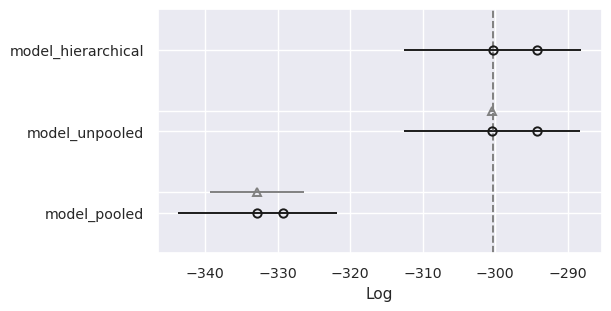

In [207]:
az.plot_compare(comp_df);